# Initial Data Exploration

![image](http://j.t.free.fr/ibm/losalamos.png)

The dataset has been provided by Los Alamos National Laboratory in the context of a competitions organized on the website Kaggle. The data are from a experiment conducted on rock in a double direct shear geometry subjected to bi-axial loading, a classic laboratory earthquake model. "Two fault gouge layers are sheared simultaneously while subjected to a constant normal load and a prescribed shear velocity. The laboratory faults fail in repetitive cycles of stick and slip that is meant to mimic the cycle of loading and failure on tectonic faults. While the experiment is considerably simpler than a fault in Earth, it shares many physical characteristics."

The dataset consists of a train set and a test set :
- the train set (`train.csv.zip`) is a continuous time series of experiment data
- the test set (`test.zip`) is composed of segments (=1500,000 points) of data recording (`acoustic_data` only). 
"Both the training and the testing set come from the same experiment. There is no overlap between the training and testing sets, that are contiguous in time." 

The features are :
- `acoustic_data` :  is "recorded using a piezoceramic sensor, which outputs a voltage upon deformation by incoming seismic waves" (integer).
- `time_to_failure` : corresponds to "the time remaining before the next laboratory earthquake" (decimal).

The aim is to predict the `time_to_failure` from the knowledge of the `acoustic_data` feature.

![image](http://j.t.free.fr/ibm/experiment3.jpg)


## 1 Data download and preparation

Even if the dataset seems simple, the size and the nature of it makes in difficult to explore the data using local ressources. I made the choice to use Apache Spark to perform this exploration. But first it's needed to run a few command to get the data.   

In [3]:
# ! pip install kaggle
# ! echo "{\"username\":\"xxxxxxxxxx\",\"key\":\"xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx\"}" > ~/.kaggle/kaggle.json
# ! chmod 600 ~/.kaggle/kaggle.json
# ! ~/.local/bin/kaggle competitions download -c LANL-Earthquake-Prediction
# ! ls
# ! mkdir kdata
# ! mv sample_submission.csv kdata/sample_submission.csv 
# ! mv test.zip kdata/test.zip
# ! mv train.csv.zip kdata/train.csv.zip
# ! unzip kdata/train.csv.zip -d kdata
# ! chmod 777 kdata/train.csv
# ! mkdir kdata/test
# ! unzip kdata/test.zip -d kdata/test  
# 10% sample for tests : 
# ! head -n62914548 kdata/train.csv > kdata/train0.csv
# ! rm -R kdata/train
# ! mkdir kdata/train
# ! sed '1d' kdata/train.csv > kdata/train_nh.csv
# ! split -l 150000 kdata/train_nh.csv kdata/train/Seg_ --numeric-suffixes=1 -a 5
# ! rm -R kdata/train_nh.csv

! echo "train.csv"
! echo "--------------------"
! head kdata/train.csv
! echo ""
! echo "test/seg_51f6fd.csv"
! echo "--------------------"
! head kdata/test/seg_51f6fd.csv 

# ! rm -R kdata/train.parquet*

# ! ls kdata/train

train.csv
--------------------
acoustic_data,time_to_failure
12,1.4690999832
6,1.4690999821
8,1.469099981
5,1.4690999799
8,1.4690999788
8,1.4690999777
9,1.4690999766
7,1.4690999755
-5,1.4690999744

test/seg_51f6fd.csv
--------------------
acoustic_data
6
5
-1
3
7
5
8
8
6


## 2 Global statistical values
We will start by computing the main statistical measures (mean, standatd deviation, minimum, maximum, skew and kurtosis) and plot the values distributions.

### 2.1 Train data

In [4]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, DoubleType

schema = StructType([
    StructField("x", DoubleType(), True),
    StructField("y", DoubleType(), True)])

df = spark.read.csv("kdata/train.csv", header=True,schema=schema)
df.write.parquet("kdata/train.0.parquet")
df = None

In [5]:
df_x = spark.read.parquet("kdata/train.0.parquet")
summary = df_x.describe()
summary.show()

+-------+------------------+------------------+
|summary|                 x|                 y|
+-------+------------------+------------------+
|  count|         629145480|         629145480|
|   mean| 4.519467573700124| 5.678291712978867|
| stddev|10.735707249511096|3.6726965194436416|
|    min|           -5515.0|   9.5503963166E-5|
|    max|            5444.0|           16.1074|
+-------+------------------+------------------+



We can already notice for the `acoustic_data` feature (x), that values are very narrowed distributed around the mean but that there is a wide range of values (max and min are more than 500 times the standard deviation !). It is important also to notice that the value is an integer. 

The `time_to_failure` feature (y) has a positive value from close to 0 to a little more than 16, the mean little closer to 0 than to 8.    

#### 2.1.1 "acoustic_data" (x) feature

In [6]:
ls_summary = summary.collect()
x_count = ls_summary[0]['x']
x_mean  = ls_summary[1]['x']
x_std   = ls_summary[2]['x']
x_min   = ls_summary[3]['x']
x_max   = ls_summary[4]['x']

In [7]:
df_x.createOrReplaceTempView("data")
x_skew = spark.sql("""SELECT 
    (1/COUNT(x))*SUM(POWER(x-{},3)/POWER({},3)) as skew 
FROM data""".format(x_mean,x_std)).first().skew
print("Skewness: {:.08f}".format(float(x_skew)))

Skewness: 2.00416327


The skewness is positive, showing a slight skew with the mode at the left of the mode.

In [8]:
df_x.createOrReplaceTempView("data")
x_kurt = spark.sql("""SELECT 
    (1/COUNT(x))*SUM(POWER(x-{},4)/POWER({},4)) as kurt 
FROM data""".format(x_mean,x_std)).first().kurt
print("Kurtosis: {:.08f}".format(float(x_kurt)))

Kurtosis: 21075.30272028


The kurtosis value is very important, showing the distribution is very tight around the mean.   

In [9]:
from pyspark.ml.feature import Bucketizer

splits = [-float("inf")]+[1.0*i for i in range(-100,100,1)]+[float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="x", outputCol="bx")

bucketedData = bucketizer.transform(df_x)

bucketedData.createOrReplaceTempView("data")
spark.sql("SELECT count(*) as N FROM data GROUP BY bx ORDER BY bx").createOrReplaceTempView("data_agg")
df_n = spark.sql("SELECT N FROM data_agg")
agg_x = df_n.collect()



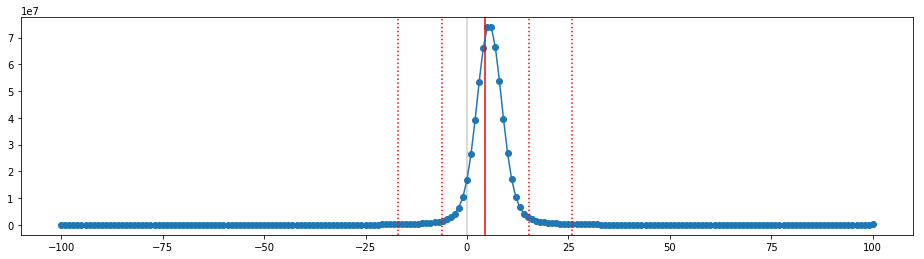

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

t = range(len(agg_x))
t = [v-100 for v in t ]
fig = plt.figure(figsize=(16,4))
# ax.set_xlim(0,100)

# plt.axvline(x_mean,color='red')
plt.scatter(t, agg_x)
plt.axvline(0,color='black', alpha=0.2)
plt.axvline(float(x_mean),color='red')
plt.axvline(float(x_mean)-2*float(x_std),color='red',ls=':')
plt.axvline(float(x_mean)-float(x_std),color='red',ls=':')
plt.axvline(float(x_mean)+float(x_std),color='red',ls=':')
plt.axvline(float(x_mean)+2*float(x_std),color='red',ls=':')
plt.plot(t, agg_x)



We can see on this density distribution plot, that kurtosis is important. Some high values in the bucket 100 (bucket with values between 100 and +inf) can be noticed.

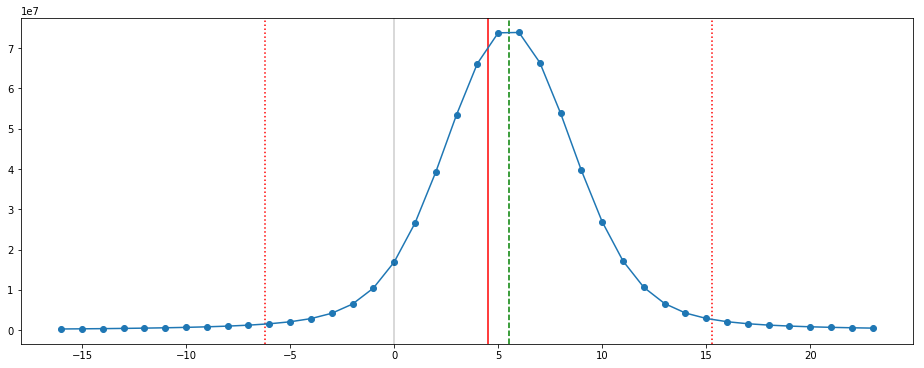

In [11]:
t = range(len(agg_x))
t = [v-100 for v in t ]
fig = plt.figure(figsize=(16,6))
# ax.set_xlim(0,100)

# plt.axvline(x_mean,color='red')
plt.scatter(t[84:124], agg_x[84:124])
plt.axvline(0,color='black', alpha=0.2)
plt.axvline(float(x_mean),color='red')
plt.axvline(5.5,color='green', ls="--")
plt.axvline(float(x_mean)-float(x_std),color='red',ls=':')
plt.axvline(float(x_mean)+float(x_std),color='red',ls=':')
plt.plot(t[84:124], agg_x[84:124])



We can notice that the mean is at the left to the mode, which is not the sign of a positive skewness. This should be a consequence of the values in the greater positive area. 

#### 2.1.2 "time_to_failure" (y) feature

In [12]:
y_count = ls_summary[0]['y']
y_mean  = ls_summary[1]['y']
y_std   = ls_summary[2]['y']
y_min   = ls_summary[3]['y']
y_max   = ls_summary[4]['y']

In [13]:
df_x.createOrReplaceTempView("data")
y_skew = spark.sql("""SELECT 
    (1/COUNT(y))*SUM(POWER(y-{},3)/POWER({},3)) as skew 
FROM data""".format(y_mean,y_std)).first().skew
print("Skewness: {:.08f}".format(float(y_skew)))

Skewness: 0.45648435


The skewness is positive but lower than 1, showing a slight skew in direction of 0 we already guessed from the summary and from the nature of the data.

In [15]:
df_x.createOrReplaceTempView("data")
y_kurt = spark.sql("""SELECT 
    (1/COUNT(y))*SUM(POWER(y-{},4)/POWER({},4)) as kurt 
FROM data""".format(y_mean,y_std)).first().kurt
print("Kurtosis: {:.08f}".format(float(y_kurt)))


Kurtosis: 2.46216932


In [16]:
from pyspark.ml.feature import Bucketizer

splits = [-float("inf")]+[1.0*i for i in range(0,18,1)]+[float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="y", outputCol="by")

bucketedData = bucketizer.transform(df_x)

bucketedData.createOrReplaceTempView("data")
spark.sql("SELECT count(*) as N FROM data GROUP BY by ORDER BY by").createOrReplaceTempView("data_agg")
df_n = spark.sql("SELECT N FROM data_agg")
agg_y = df_n.collect()



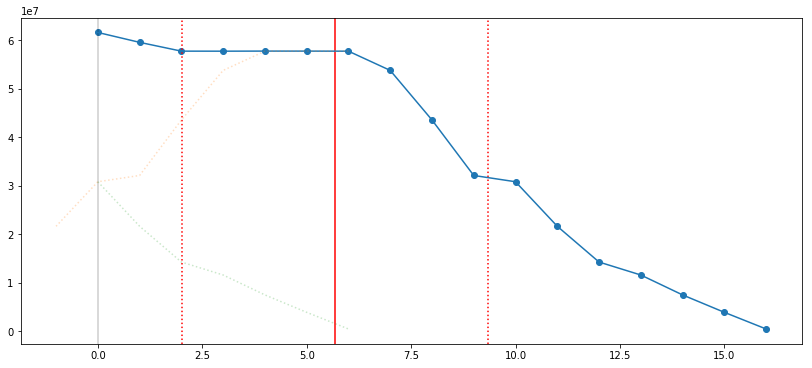

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

t = range(len(agg_y))
ti = [10-i for i in t]
agg_yi = agg_y[4:12]
ti = ti[4:12]
agg_yj = agg_y[10:]
tj = [i-10 for i in t[10:]]
# agg_yk = [agg_yi[6-i].N+agg_yj[i].N for i in range(5)]

fig = plt.figure(figsize=(14,6))

plt.scatter(t, agg_y)
plt.axvline(0,color='black', alpha=0.2)
plt.axvline(float(y_mean),color='red')
plt.axvline(float(y_mean)-float(y_std),color='red',ls=':')
plt.axvline(float(y_mean)+float(y_std),color='red',ls=':')
plt.plot(t, agg_y)
plt.plot(ti, agg_yi, ls=":", alpha=0.25)
plt.plot(tj, agg_yj, ls=":", alpha=0.25)
# plt.plot(t[0:5], agg_yk, ls="--", alpha=0.5)
# plt.plot(ti[:3], agg_yi[:3], ls="--", alpha=0.5)


The density distribution looks close to a folded normal distribution.

### 2.2 Test data

In [18]:
import os
files = os.listdir(os.path.join("kdata","test"))
print("The test set consists of {} segment of 150,000 observations each. ".format(len(files)))

The test set consists of 2624 segment of 150,000 observations each. 


#### 2.2.1 Files

In [19]:
# ! rm -R kdata/test.parquet*

import os
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, DoubleType, StringType
from pyspark.sql.functions import lit

schema = StructType([StructField("x", DoubleType(), True)])

files = os.listdir(os.path.join("kdata","test"))
for f in files:
    df = spark.read.csv(os.path.join("kdata", "test", f), header=True,schema=schema)
    df = df.withColumn("f", lit(f))
    df.write.parquet("kdata/test.0.parquet", mode="append")


#### 2.2.2 "acoustic_data" (z) feature

In [20]:
df_z = spark.read.parquet("kdata/test.0.parquet")
summary = df_z.describe()
summary.show()

+-------+------------------+--------------+
|summary|                 x|             f|
+-------+------------------+--------------+
|  count|         393600000|     393600000|
|   mean| 4.148615569105691|          null|
| stddev|11.008194128396102|          null|
|    min|           -6323.0|seg_00030f.csv|
|    max|            6741.0|seg_ffe7cc.csv|
+-------+------------------+--------------+



#### 2.2.2 "acoustic_data" (z) feature

In [21]:
ls_summary = summary.collect()
z_count = ls_summary[0]['x']
z_mean  = ls_summary[1]['x']
z_std   = ls_summary[2]['x']
z_min   = ls_summary[3]['x']
z_max   = ls_summary[4]['x']

In [22]:
df_z.createOrReplaceTempView("data")
z_skew = spark.sql("""SELECT 
    (1/COUNT(x))*SUM(POWER(x-{},3)/POWER({},3)) as skew 
FROM data""".format(z_mean,z_std)).first().skew
print("Skewness: {:.08f}, (recall : on train set, x skewness = {:.08f})".format(float(z_skew), float(x_skew)))

Skewness: -2.66045772, (recall : on train set, x skewness = 2.00416327)


The skewness is negative, which doesn't align with what was observed on the train set.   

In [23]:
df_z.createOrReplaceTempView("data")
z_kurt = spark.sql("""SELECT 
    (1/COUNT(x))*SUM(POWER(x-{},4)/POWER({},4)) as kurt 
FROM data""".format(z_mean,z_std)).first().kurt
print("Kurtosis: {:.08f}, (recall : on train set, x kurtosis = {:.08f})".format(float(z_kurt), float(x_kurt)))

Kurtosis: 25856.59983142, (recall : on train set, x kurtosis = 21075.30272028)


The kurtosis value is still very important, a little bigger than on the train set.   

In [24]:
from pyspark.ml.feature import Bucketizer

splits = [-float("inf")]+[1.0*i for i in range(-100,100,1)]+[float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="x", outputCol="bz")

bucketedData = bucketizer.transform(df_z)

bucketedData.createOrReplaceTempView("data")
spark.sql("SELECT count(*) as N FROM data GROUP BY bz ORDER BY bz").createOrReplaceTempView("data_agg")
df_n = spark.sql("SELECT N FROM data_agg")
agg_z = df_n.collect()


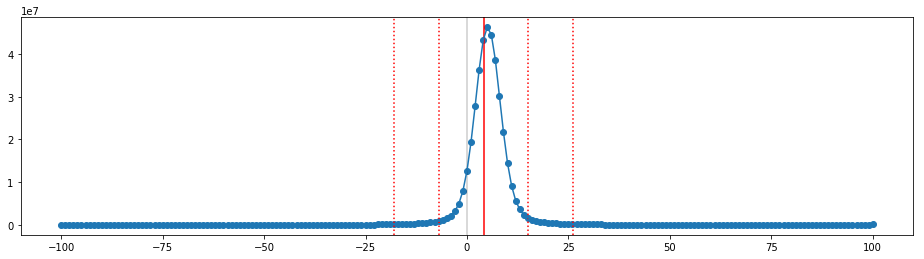

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

t = range(len(agg_z))
t = [v-100 for v in t]
fig = plt.figure(figsize=(16,4))
# ax.set_xlim(0,100)

# plt.axvline(x_mean,color='red')
plt.scatter(t, agg_z)
plt.axvline(0,color='black', alpha=0.2)
plt.axvline(float(z_mean),color='red')
plt.axvline(float(z_mean)-2*float(z_std),color='red',ls=':')
plt.axvline(float(z_mean)-float(z_std),color='red',ls=':')
plt.axvline(float(z_mean)+float(z_std),color='red',ls=':')
plt.axvline(float(z_mean)+2*float(z_std),color='red',ls=':')
plt.plot(t, agg_z)


We can notice the same peak in the bucket 100 that shows those high values are also found in the test set.

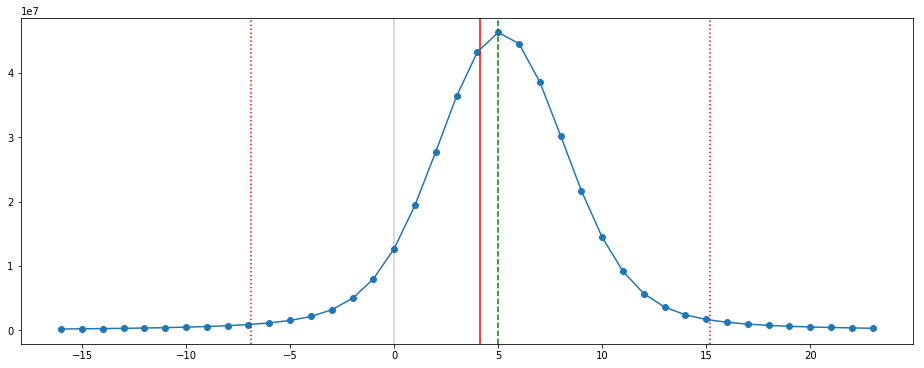

In [26]:
t = range(len(agg_z))
t = [v-100 for v in t ]
fig = plt.figure(figsize=(16,6))
# ax.set_xlim(0,100)

# plt.axvline(x_mean,color='red')
plt.scatter(t[84:124], agg_z[84:124])
plt.axvline(0,color='black', alpha=0.2)
plt.axvline(float(z_mean),color='red')
plt.axvline(5.0,color='green', ls="--")
plt.axvline(float(z_mean)-float(z_std),color='red',ls=':')
plt.axvline(float(z_mean)+float(z_std),color='red',ls=':')
plt.plot(t[84:124], agg_z[84:124])



The observed mode in closer to 5 compared to 5.5 value of the train set. 

## 3 Visualization of some samples

### 3.1 Train data

In [29]:
import os
import random
import numpy as np
import pandas as pd

folder = os.path.join("kdata", "train")
files = os.listdir(folder)
files.sort()
idx = [i for i in range(len(files))]
random.shuffle(idx)
idx = [3297+7,3297+8,3297+9, 3271, 3872]+idx

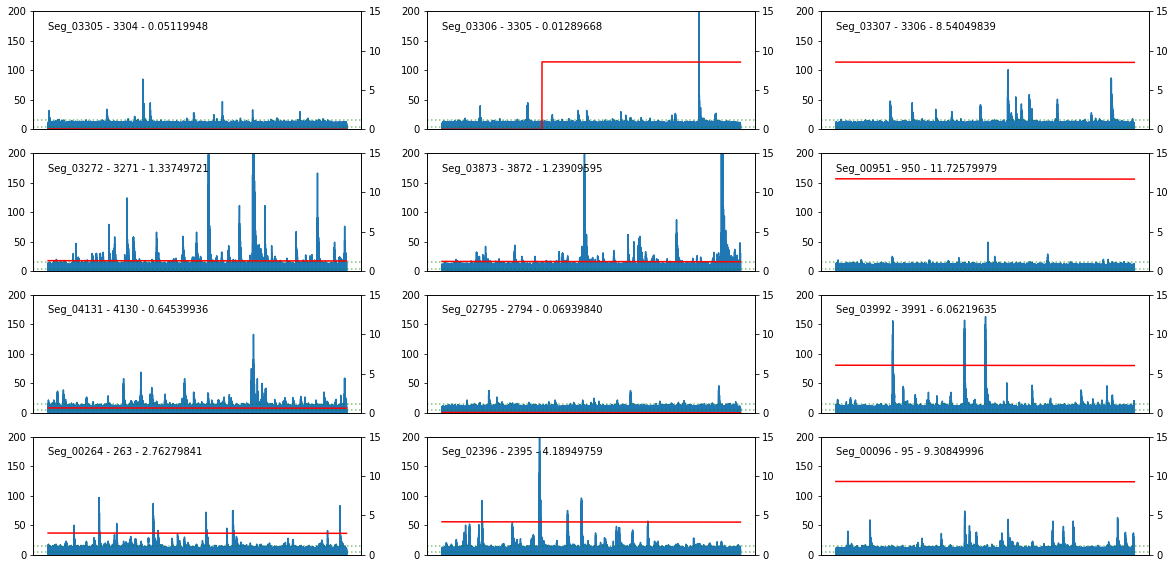

In [30]:
# print(float(x_mean))

fig = plt.figure(figsize=(20,10))
for i in range(12):
    file_path = os.path.join(folder, files[idx[i]])
    df = pd.read_csv(file_path, header=None)
    s = fig.add_subplot(4, 3, i + 1, xticks=[])
    s.set_ylim(0, 200)
    s.text(10,170, "{} - {} - {:.08f}".format(files[idx[i]], idx[i], df.iloc[1,-1]) )#,  pad=-20.0)
    s.plot(df[0])
    s.axhline(float(x_mean)+0*float(x_std), color='green', ls=":", alpha=0.5)
    s.axhline(float(x_mean)+1*float(x_std), color='green', ls=":", alpha=0.5)
    s2 = s.twinx()
    s2.set_ylim(0, 15)
    s2.plot(df[1], 'r')

From those plot of segment of the test data (150,000 observations segments), we can notice that the `time_to_failure` is nearly constant at the scale of a segment, unless a failure occurs during the segment.

Also, it seems to me that most of the `acoustic_data` that we have around the mean could be noise. Let's have a look at a zoomed sample of some data : 


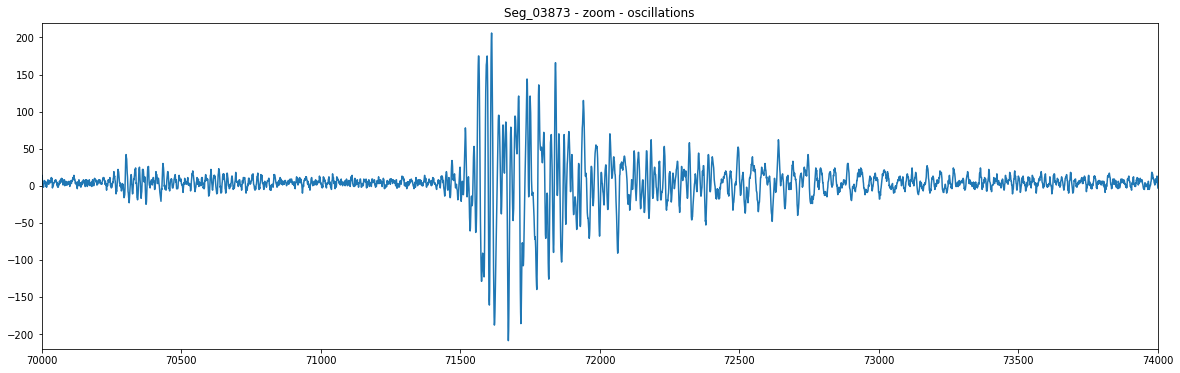

In [8]:
import os
import pandas as pd

folder = os.path.join("kdata", "train")
file_path = os.path.join(folder, "Seg_03873")
pdf = pd.read_csv(file_path, header=None)
fig = plt.figure(figsize=(20,6))
plt.plot(pdf[0])
plt.xlim(70000, 74000)
plt.ylim(-220, 220)
title = plt.title("Seg_03873 - zoom - oscillations")

We can notice wave form oscillations. Another way to deal with time series is to translate them in the frequency domain using a Fourier transformation. 

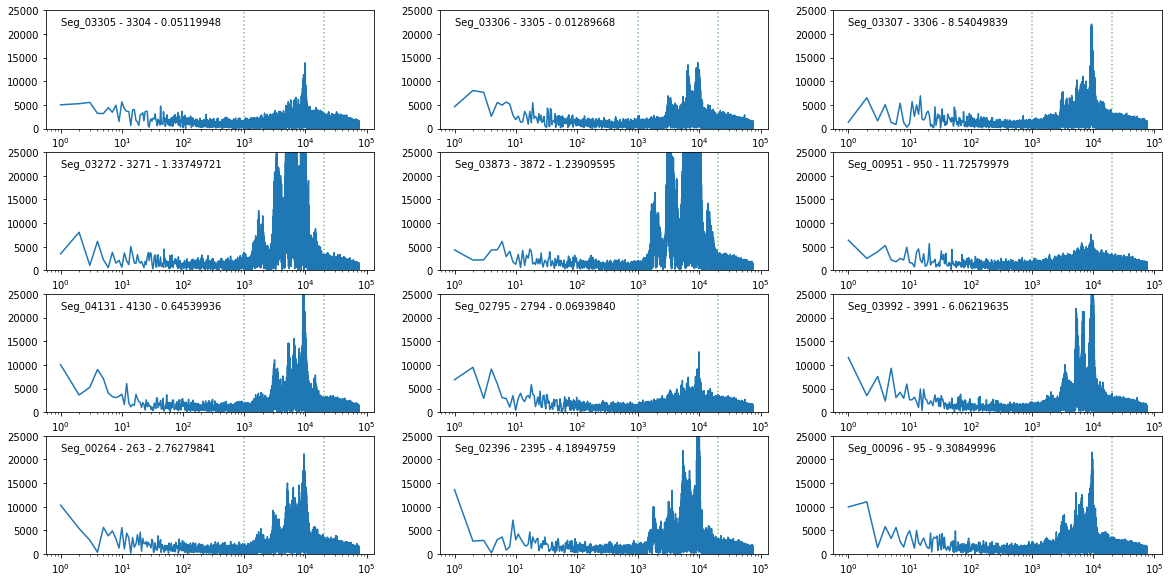

In [33]:
fig = plt.figure(figsize=(20,10))
for i in range(12):
    file_path = os.path.join(folder, files[idx[i]])
    df = pd.read_csv(file_path, header=None)
    s = fig.add_subplot(4, 3, i + 1, xticks=[])
    s.text(1,22000, "{} - {} - {:.08f}".format(files[idx[i]], idx[i], df.iloc[1,-1]) )#,  pad=-20.0)
    plt.xscale('log')
    s.axvline(20000, color='green', ls=":", alpha=0.5)
    s.axvline(1000, color='green', ls=":", alpha=0.5)
    fft = np.abs(np.fft.fft(df[0])) # fft computing and normalization
    s.plot(fft[1:75000])
    s.set_ylim(0, 25000)


The range between 1,000 and 20,000 is where most of the signal is epxressed.

### 2.2 Test data

In [34]:
import os
import random
import numpy as np

folder = os.path.join("kdata", "test")
files = os.listdir(folder)
files.sort()
idx = [i for i in range(len(files))]
random.shuffle(idx)
# idx = [3297+7,3297+8,3297+9, 3271, 3872]+idx

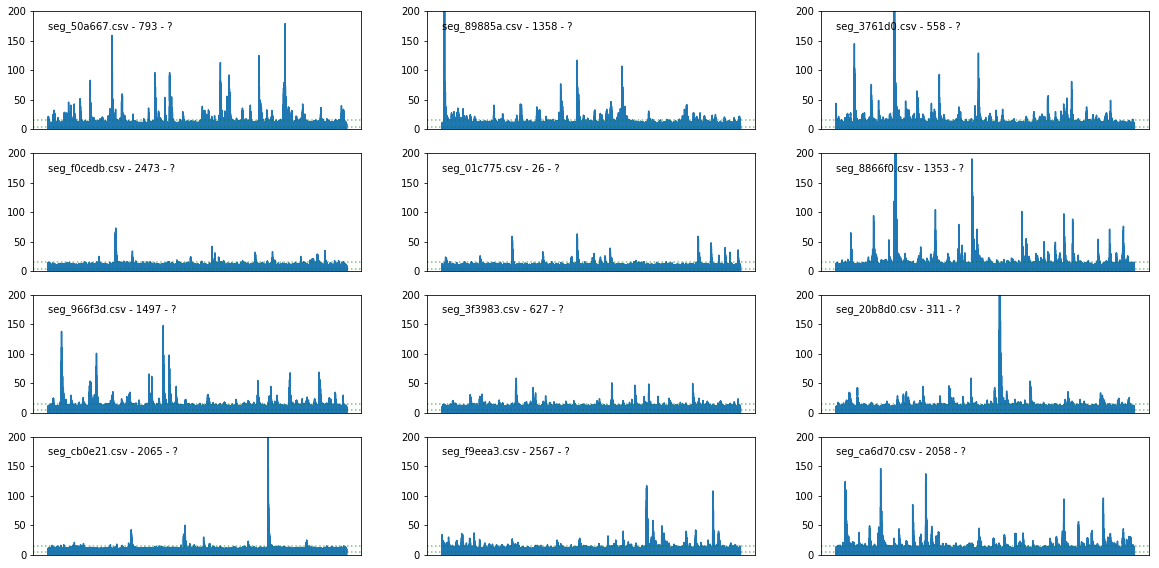

In [35]:
# print(float(x_mean))

fig = plt.figure(figsize=(20,10))
for i in range(12):
    file_path = os.path.join(folder, files[idx[i]])
    df = pd.read_csv(file_path)
    s = fig.add_subplot(4, 3, i + 1, xticks=[])
    s.set_ylim(0, 200)
    s.text(10,170, "{} - {} - ?".format(files[idx[i]], idx[i]) )#,  pad=-20.0)
    s.plot(df["acoustic_data"])
    s.axhline(float(x_mean)+0*float(x_std), color='green', ls=":", alpha=0.5)
    s.axhline(float(x_mean)+1*float(x_std), color='green', ls=":", alpha=0.5)


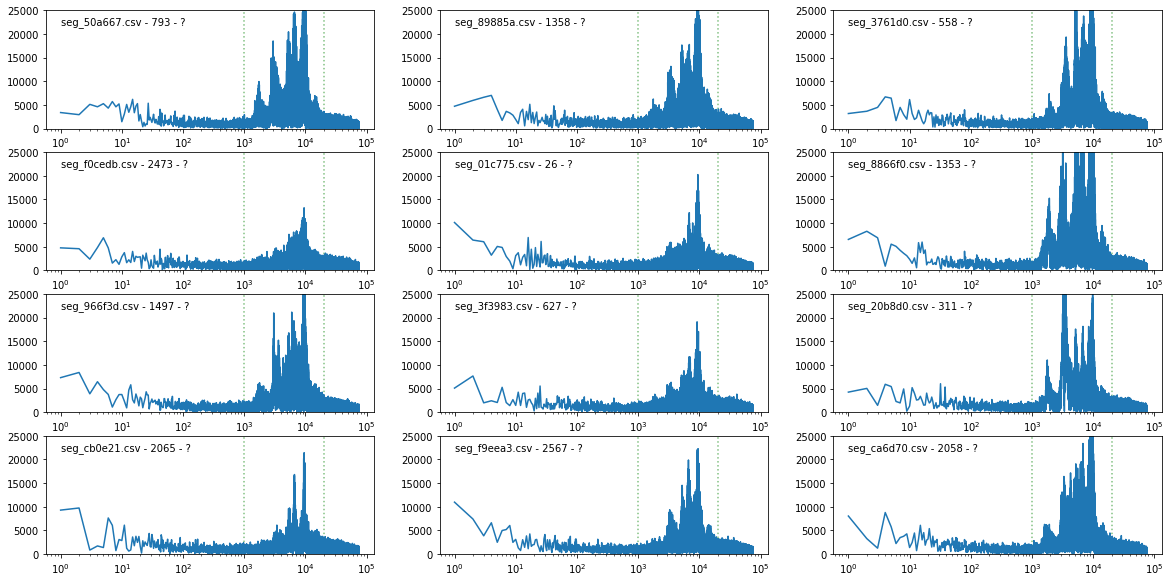

In [37]:
fig = plt.figure(figsize=(20,10))
for i in range(12):
    file_path = os.path.join(folder, files[idx[i]])
    df = pd.read_csv(file_path)
    s = fig.add_subplot(4, 3, i + 1, xticks=[])
    s.text(1,22000, "{} - {} - ?".format(files[idx[i]], idx[i]) )#,  pad=-20.0)
    plt.xscale('log')
    s.axvline(20000, color='green', ls=":", alpha=0.5)
    s.axvline(1000, color='green', ls=":", alpha=0.5)
    fft = np.abs(np.fft.fft(df["acoustic_data"])) # fft computing and normalization
    s.plot(fft[1:75000])
    s.set_ylim(0, 25000)


## 4 Overview
Note : the overview comes at the end only beacuse it has been made easy to do after the ETL phase. 

### 4.1 Overview of the continuous train data 

In [1]:
df = spark.read.parquet(os.path.join("kdata","train.parquet"))

In [2]:
df.createOrReplaceTempView("data")
df_temp = spark.sql("""
SELECT seg, AVG(y) as y, 
AVG(ABS(x)) as x_mean, MAX(ABS(x)) as x_max
FROM data 
WHERE set = 0 
GROUP BY seg ORDER BY seg
""" )
pdf = df_temp.toPandas()

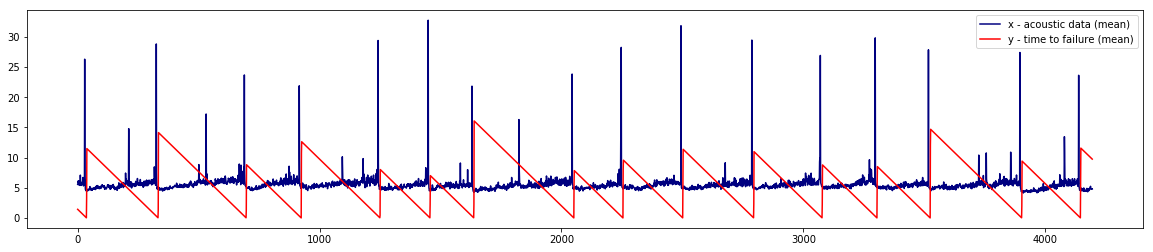

In [6]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20,4))
plt.plot(pdf["x_mean"][:], color="navy", label="x - acoustic data (mean)")
plt.plot(pdf["y"][:], color="r", label="y - time to failure (mean)")
plt.legend()


We can see that the test data consists of 17 quakes. We can notice that there is a pattern before the quakes happens with the signal increasing, making a peak and the drecreasing. Let's zoom on one of those quake.

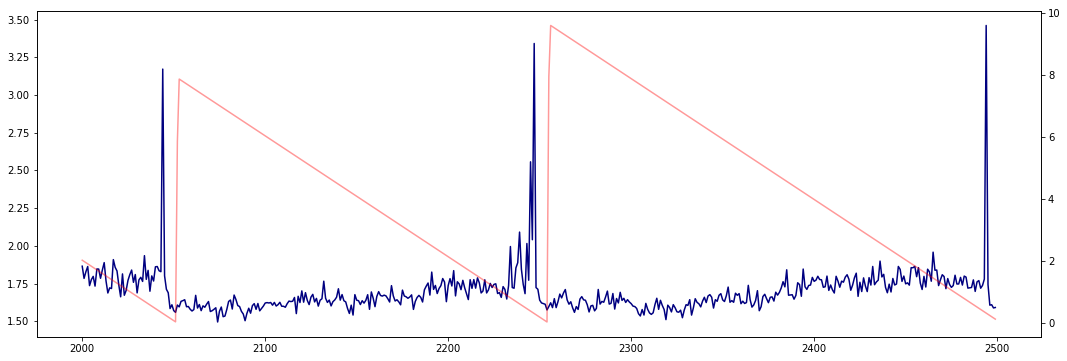

In [4]:
import numpy as np

idxmi, idxma = 2000, 2500  
fig = plt.figure(figsize=(18,6))
s1 = plt.subplot(1,1,1)
s1.plot(np.log(pdf["x_mean"])[idxmi:idxma], color="navy")
s2 = s1.twinx()
plt.plot(pdf["y"][idxmi:idxma], color="r", alpha=0.4)


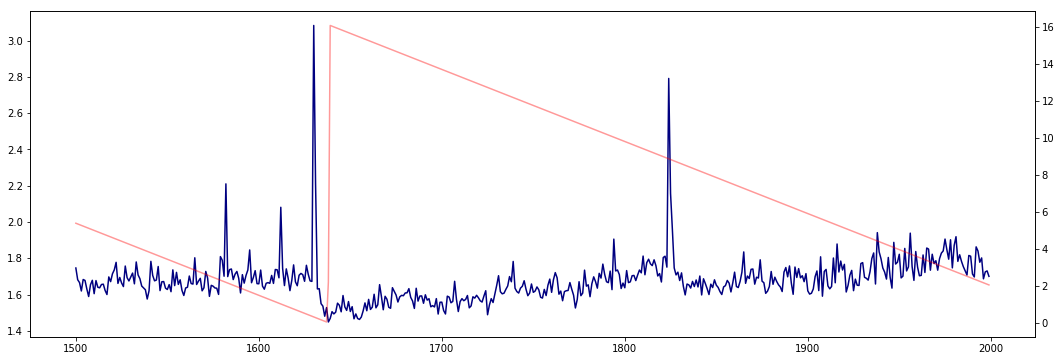

In [5]:
idxmi, idxma = 1500, 2000  
fig = plt.figure(figsize=(18,6))
s1 = plt.subplot(1,1,1)
s1.plot(np.log(pdf["x_mean"])[idxmi:idxma], color="navy")
s2 = s1.twinx()
plt.plot(pdf["y"][idxmi:idxma], color="r", alpha=0.4)


### 4.2 Overview of the continuous test data 

In [44]:
df = spark.read.parquet(os.path.join("kdata", "test.parquet"))

In [45]:
df.createOrReplaceTempView("data")
df_temp = spark.sql("""
SELECT seg, AVG(y) as y, 
AVG(ABS(x)) as x_mean, MAX(ABS(x)) as x_max
FROM data 
WHERE set = 1 
GROUP BY seg ORDER BY seg
""" )
pdf = df_temp.toPandas()

(0, 4195)

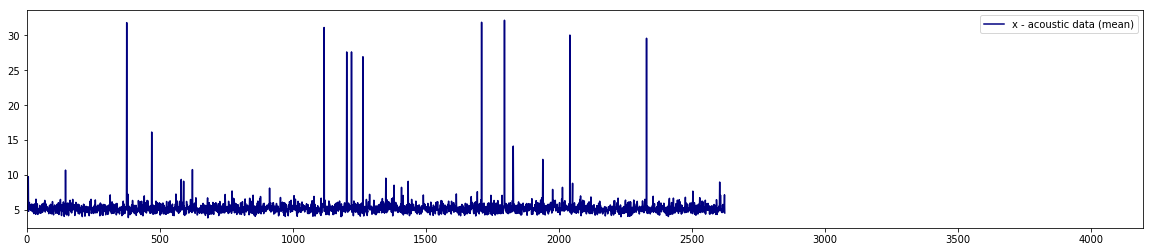

In [46]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20,4))
plt.plot(pdf["x_mean"][:], color="navy", label="x - acoustic data (mean)")
plt.legend()
plt.xlim(0,4195)


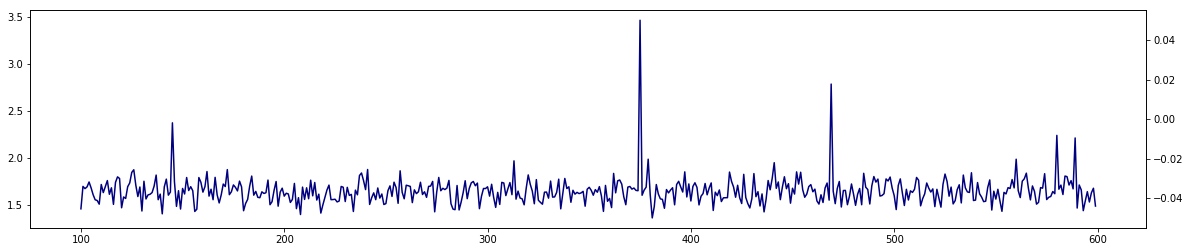

In [47]:
idxmi, idxma = 100, 600  
fig = plt.figure(figsize=(20,4))
s1 = plt.subplot(1,1,1)
s1.plot(np.log(pdf["x_mean"])[idxmi:idxma], color="navy")
s2 = s1.twinx()
plt.plot(pdf["y"][idxmi:idxma], color="r", alpha=0.4)


## 5 Conclusions

We have several aspects of the data that have observed
1. on the input data, we have a time series with one feature but a large number of observations
2. most of the observations, have a low value and are close to 0 and seems to be noise, which makes sense with the nature of the source (sensor)
2. observations can take a very high values on rare events (peaks) and have episods of higher activities with oscillations
3. the frequency domain seems to be an interesting angle to extract value from the data and get rid of the noise
4. the target is a time countdown before a quake ; it is almost constant at 1 segment scale unless a quake happens in the window
5. a pattern is cleary visible in the train data with the mean of the acoustic signal increasing, a peak appearing, then then the value decreasing before the quakes appears
6. this pattern doesn't lead each time to a quake, could be a false signal in some circumstances
7. this pattern doesn't appear as clearly on the test data, opening a doubt on the fact that the segments of the test data is consitent with the train data   
8. the big picture of the test data open a doubt on the fact that the test segments are contiguous in time
